## Foraminifera Data

In [1]:
import numpy as np
import pandas as pd
from grainsize import Forams

Import raw foraminifera counting data for size fraction of 125 microns

In [2]:
sr19 = Forams(fname="./data-files/mp-files/sr19-forams.csv", size_fraction=125)
sr21 = Forams(fname="./data-files/mp-files/sr21-forams.csv", size_fraction=125)

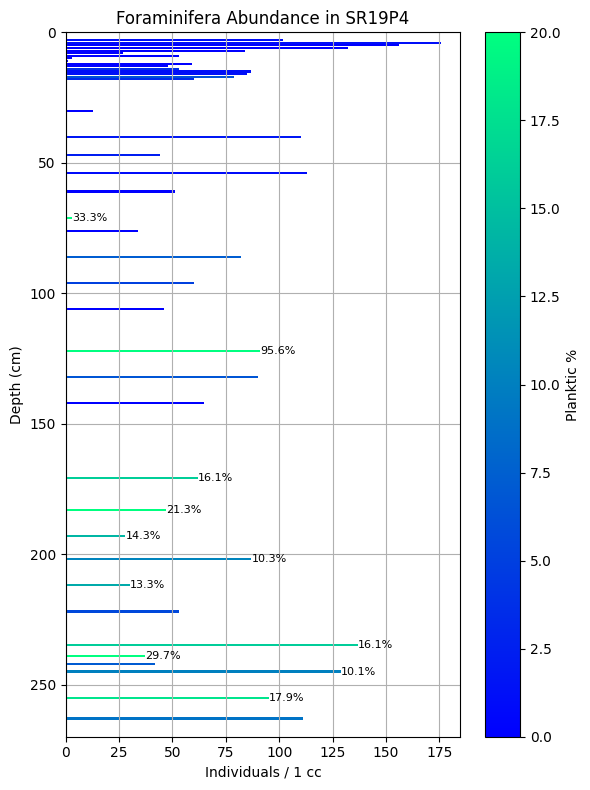

In [3]:
sr19_forams_plot = sr19.plot_forams(
    core_name="SR19P4",
    limit_sm=True,
    sm_limit=20
)

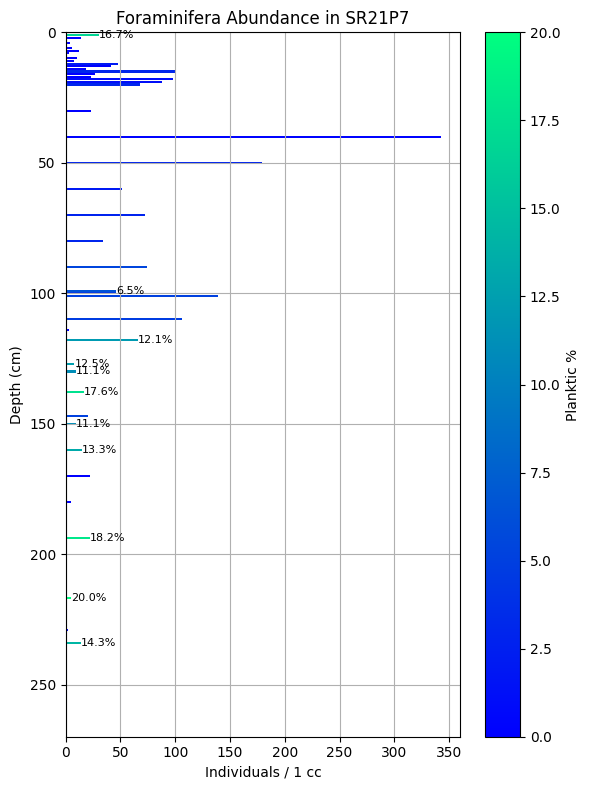

In [4]:
sr21_forams_plot = sr21.plot_forams(
    core_name="SR21P7",
    limit_sm=True,
    sm_limit=20
)